In [38]:
import util
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [39]:
y, train, val, test = util.get_labels_and_split_augmented() # Can use anything here

y_train, y_val, y_test = y[train], y[val], y[test]

y_keep = y_train

y_train = tf.one_hot(y_train, depth=8)
y_val   = tf.one_hot(y_val,   depth=8)
y_test  = tf.one_hot(y_test,  depth=8)

low_res = util.get_low_res_augmented() # Match abvoe
# low_res = np.load('low_res.npy')

# low_res.reshape(low_res.shape[0], -1)

X_train = low_res[train]
X_val = low_res[val]
X_test = low_res[test]

7301it [00:09, 779.25it/s] 


In [40]:
edge_count_train = []

for i in tqdm(range(X_train.shape[0])):
    gray_image = cv2.cvtColor(X_train[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_train.append(edges.sum())

edge_count_train = np.array(edge_count_train)

edge_count_val = []

for i in tqdm(range(X_val.shape[0])):
    gray_image = cv2.cvtColor(X_val[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_val.append(edges.sum())

edge_count_val = np.array(edge_count_val)

edge_count_test = []

for i in tqdm(range(X_test.shape[0])):
    gray_image = cv2.cvtColor(X_test[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_test.append(edges.sum())

edge_count_test = np.array(edge_count_test)

100%|██████████| 704/704 [00:00<00:00, 5571.11it/s]


In [41]:

X_train_edge = X_train[edge_count_train > 800000]
y_train_edge = y_train[edge_count_train > 800000]
X_val_edge = X_val[edge_count_val > 800000]
y_val_edge = y_val[edge_count_val > 800000]
X_test_edge = X_test[edge_count_test > 800000]
y_test_edge = y_test[edge_count_test > 800000]

In [42]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(147, 147, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
history = model.fit(X_train_edge, y_train_edge, validation_data=(X_val_edge, y_val_edge), epochs=3, batch_size=32)

Epoch 1/3
81/81 [==============================] - 135s 2s/step - loss: 1.2912 - accuracy: 0.5792 - val_loss: 1.2327 - val_accuracy: 0.5831
Epoch 2/3
81/81 [==============================] - 145s 2s/step - loss: 1.2308 - accuracy: 0.5964 - val_loss: 1.2453 - val_accuracy: 0.5896
Epoch 3/3
81/81 [==============================] - 143s 2s/step - loss: 1.1744 - accuracy: 0.6085 - val_loss: 1.2125 - val_accuracy: 0.5896


In [52]:

val_loss_edge, val_accuracy_edge = model.evaluate(X_val_edge, y_val_edge)

10/10 [==============================] - 14s 1s/step - loss: 1.2125 - accuracy: 0.5896


In [58]:
edge_acc = np.array(y_val[edge_count_val < 800000] == 1).mean() * 8
small = y_val[edge_count_val < 800000].shape[0]
big = y_val[edge_count_val >= 800000].shape[0]
val_accuracy = val_accuracy_edge * big / (small + big) + edge_acc * small / (small + big)

print("val acc: " + str(val_accuracy))

val acc: 0.6735751256732743


In [54]:
y_train[edge_count_train < 800000]

<tf.Tensor: shape=(551, 8), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)>

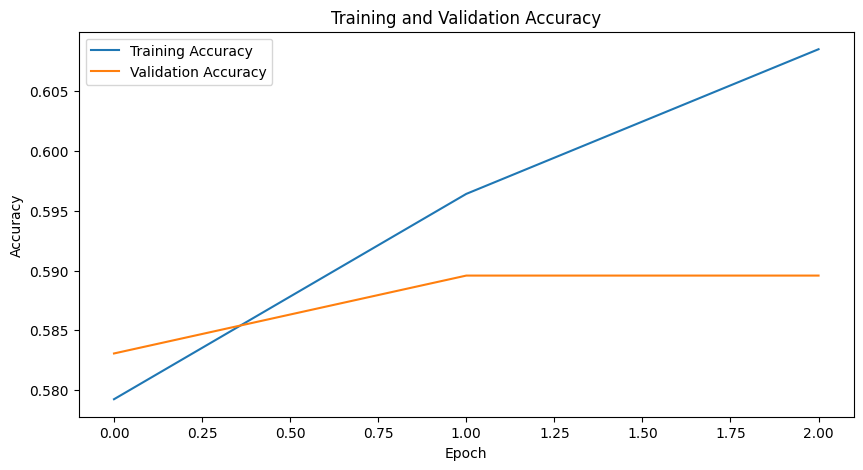

In [55]:

# test_loss, test_accuracy = cnn.evaluate(X_test, y_test)

# print("test acc: " + str(test_accuracy))

# cnn.save('low_cnn.keras')

training_loss = history.history["accuracy"]
validation_loss = history.history["val_accuracy"]

plt.figure(figsize=(10,5))
plt.plot(training_loss, label="Training Accuracy")
plt.plot(validation_loss, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



In [56]:
y, train, val, test = util.get_labels_and_split()

y_train, y_val, y_test = y[train], y[val], y[test]

y_train = tf.one_hot(y_train, depth=8)
y_val   = tf.one_hot(y_val,   depth=8)
y_test  = tf.one_hot(y_test,  depth=8)

low_res = util.get_low_res()
# low_res = np.load('low_res.npy')

# low_res.reshape(low_res.shape[0], -1)

X_train = low_res[train]
X_val = low_res[val]
X_test = low_res[test]

edge_count_train = []

for i in tqdm(range(X_train.shape[0])):
    gray_image = cv2.cvtColor(X_train[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_train.append(edges.sum())

edge_count_train = np.array(edge_count_train)

edge_count_val = []

for i in tqdm(range(X_val.shape[0])):
    gray_image = cv2.cvtColor(X_val[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_val.append(edges.sum())

edge_count_val = np.array(edge_count_val)

edge_count_test = []

for i in tqdm(range(X_test.shape[0])):
    gray_image = cv2.cvtColor(X_test[i,:,:,:], cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_image, (1, 1), 0)
    edges = cv2.Canny(blurred, 10, 20)
    edge_count_test.append(edges.sum())

edge_count_test = np.array(edge_count_test)

X_train_edge = X_train[edge_count_train > 800000]
y_train_edge = y_train[edge_count_train > 800000]
X_val_edge = X_val[edge_count_val > 800000]
y_val_edge = y_val[edge_count_val > 800000]
X_test_edge = X_test[edge_count_test > 800000]
y_test_edge = y_test[edge_count_test > 800000]

3889it [00:04, 843.79it/s]
100%|██████████| 390/390 [00:00<00:00, 6150.65it/s]


In [57]:
val_loss_edge, val_accuracy_edge = model.evaluate(X_val_edge, y_val_edge)

edge_acc = np.array(y_val[edge_count_val < 800000] == 1).mean() * 8
small = y_val[edge_count_val < 800000].shape[0]
big = y_val[edge_count_val >= 800000].shape[0]
val_accuracy = val_accuracy_edge * big / (small + big) + edge_acc * small / (small + big)

print("unaugmented val acc: " + str(val_accuracy))

test_loss_edge, test_accuracy_edge = model.evaluate(X_test_edge, y_test_edge)

edge_acc = np.array(y_test[edge_count_test < 800000] == 1).mean() * 8
small = y_test[edge_count_test < 800000].shape[0]
big = y_test[edge_count_test >= 800000].shape[0]
test_accuracy = test_accuracy_edge * big / (small + big) + edge_acc * small / (small + big)

print("unaugmented test acc: " + str(test_accuracy))

10/10 [==============================] - 17s 2s/step - loss: 1.2125 - accuracy: 0.5896
unaugmented val acc: 0.6735751256732743
10/10 [==============================] - 17s 2s/step - loss: 1.2585 - accuracy: 0.5863
unaugmented test acc: 0.6743589664116884
